In [ ]:
from cleanfid import fid
fdir1 = 'retrieve/retrieve_dog/photo_of_a_dog'
fdir2 = 'logs/2023-03-26T12-52-38_dog-sdv4/samples'
score = fid.compute_kid(fdir1, fdir2)
score

In [2]:
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt
import torch

# load pt file using torch
# path = 'logs/2023-03-22T15-43-15_woman-sdv4/statics.pt'
# data = torch.load(path)
# c_sim = data.pop('c_sim')
# path = 'logs/2023-03-22T16-17-12_woman-sdv4/statics.pt'
# data2 = torch.load(path)
# c_sim_noReg = data2.pop('c_sim')

import numpy as np
import torch
# path = 'logs/2023-03-22T16-17-12_woman-sdv4/statics.pt'
# path_reg = 'logs/2023-03-22T16-34-43_woman-sdv4/statics.pt'
def to_array(dl):
    if isinstance(dl[0],torch.Tensor):
        out = [d.cpu().numpy() for d in dl]
        return np.stack(out, axis=0)
    elif isinstance(dl[0],np.ndarray):
        return np.stack(dl, axis=0)
    else:
        raise NotImplementedError('not supported type')

def process_data(path):
    out={}
    data = torch.load(path)
    c_sim = to_array(data.pop('c_sim_global'))
    c_new_global =  to_array(data.pop('c_new_global'))
    c_reg_global = to_array(data.pop('c_reg_global'))
    keys = data.keys()
    out['c_sim'] = c_sim
    # out['c_sim'] = c_sim
    for key in keys:
        weights = to_array(data[key])
        start_weight =  weights[0]
        delta_weights = weights - np.expand_dims(start_weight, axis=0)       
        # distance = np.sum(delta_weights,axis=(1,2))
        distance = np.linalg.norm(delta_weights,axis=(1,2))
        out[key + '_distance'] = distance
        # print(distance)
        # print(np.transpose(weights[1],(1,0)).shape)
        c_mapped_new = [c_n @ np.transpose(weights[i],(1,0)) for i,c_n in zip(range(len(weights)),c_new_global)]
        c_mapped_new = np.stack(c_mapped_new, axis=0)
        c_mapped_reg = [c_reg_global @ np.transpose(weights[i],(1,0)) for i in range(len(weights))]
        c_mapped_reg = np.concatenate(c_mapped_reg, axis=0)
        # print(c_mapped_reg.shape)
        out[key + '_c_mapped_new'] = c_mapped_new
        out[key + '_c_mapped_reg'] = c_mapped_reg
    return out



def draw_line(x1,x2 =None,x3= None,x4=None):
    fig, ax = plt.subplots()
    ax.plot(x1, marker='o', linestyle='-', color='r',label = '<new> + prompt')
    if x2 is not None:
        ax.plot(x2, marker='o', linestyle='--', color='g',label = '<new> + prompt, reg')
    if x3 is not None:
        ax.plot(x3, marker='s', linestyle='-', color='r',label = '<new>')
    if x4 is not None:
        ax.plot(x4, marker='s', linestyle='--', color='g',label = '<new>, reg')
    plt.legend( loc='upper right',fontsize=7)
    plt.xticks(np.arange(0,len(x1) +1),fontsize=7)
    plt.show()
    

In [9]:
# path_reg = 'logs/2023-03-23T06-22-55_woman-sdv4/statics.pt'
# out_reg = process_data(path_reg)
path = 'logs/2023-03-27T09-11-12_dog_realReg-sdv4/statics.pt'
path_reg = 'logs/2023-03-27T09-10-44_dog_genReg-sdv4/statics.pt'
out = process_data(path)
out_reg = process_data(path_reg)
c_mapped_new = []
c_mapped_reg = []
distance = []
for key in out_reg.keys():
    if 'distance' in key:
        distance.append(key)
    elif 'c_mapped_new' in key:
        c_mapped_new.append(key)
    elif 'c_mapped_reg' in key:
        c_mapped_reg.append(key)
c_mapped_reg = sorted(c_mapped_reg)
c_mapped_new = sorted(c_mapped_new)
distance = sorted(distance)

In [11]:
path_c_reg = 'logs/2023-03-27T05-43-18_dog/statics.pt'
out_c_reg = process_data(path_c_reg)


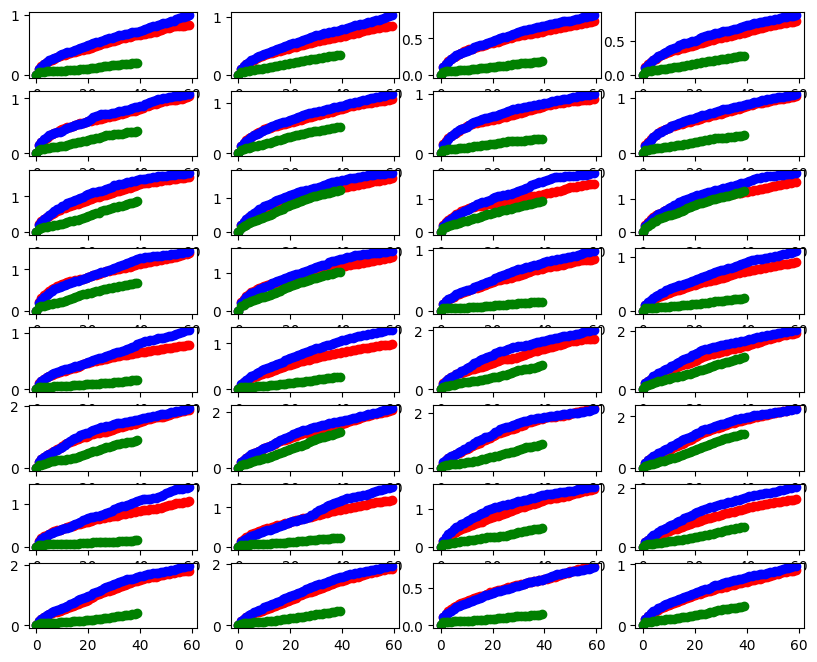

In [12]:

N = len(distance)
n = 4 # size of each array

fig, axs = plt.subplots(N // 4 + (N % 4 != 0), 4,figsize=(10, 8))
for i in range(N):
    data = out[distance[i]]
    data_reg = out_reg[distance[i]]
    data_c_reg = out_c_reg[distance[i]]
    axs[i // 4][i % 4].plot(data, marker='o', linestyle='-', color='r',linewidth=1,label = 'real reg.')
    axs[i // 4][i % 4].plot(data_reg, marker='o', linestyle='-', color='b',linewidth=1,label = 'gen. reg.')
    axs[i // 4][i % 4].plot(data_c_reg, marker='o', linestyle='-', color='g',linewidth=1,label = 'gen. reg.')
    # plt.xticks(fontsize=3)
    # plt.yticks(fontsize=3)
plt.savefig('distance.png',dpi=300)
plt.show()